# Import required libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modules for SciBert
from transformers import AutoTokenizer, AutoModel
import torch

# Modules for calculating diversity of research topics
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.special import kl_div

# Module for conducting repeated-measure tests
from scipy.stats import wilcoxon
from scipy.stats import shapiro
import statsmodels.api as sm
import pylab as py 

# Modules for linear mixed model
import statsmodels.formula.api as smf
from sklearn.utils import resample

# Modules for author colloboration
import ast
import networkx as nx
import pickle

# Ignore warning messages (only) for display purpose
import warnings
warnings.filterwarnings('ignore')

# Read data

In [95]:
# Read dataframe
df = pd.read_csv("../database/preprocessed_content_analysis.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,first_name,middle_name,last_name,email,institution,award_year,award_amount,paper_title,journal,publication_year,...,citation_2019,citation_2020,citation_2021,citation_2022,citation_2023,citation_2024,tokenized_title,normalized_title,tokenized_abstract,normalized_abstract
0,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Effect of oxidation and geometrical dimensions...,Desalination,2011,...,13,5,10,5,7,1,"['Effect', 'of', 'oxidation', 'and', 'geometri...","['effect', 'oxidation', 'geometrical', 'dimens...","['This', 'study', 'reports', 'for', 'the', 'fi...","['study', 'report', 'time', 'use', 'oxidize', ..."
1,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Synthesis and biological evaluation of new pyr...,Molecules,2014,...,13,5,10,5,7,1,"['Synthesis', 'and', 'biological', 'evaluation...","['synthesis', 'biological', 'evaluation', 'new...","['A', 'selected', 'set', 'of', 'substituted', ...","['select', 'set', 'substituted', 'pyridone', '..."
2,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Synthesis of 6-Ethyl-1, 2, 9-trioxopyrrolo [3,...",Zeitschrift für Naturforschung B,2013,...,13,5,10,5,7,1,"['Synthesis', 'of', '6', 'Ethyl-1', '2', '9', ...","['synthesis', 'ethyl-1', 'trioxopyrrolo', 'f',...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
3,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Randa M. Al-As’ ada, Mustafa M. El-abadelaha, ...",Z. Naturforsch,2013,...,13,5,10,5,7,1,"['Randa', 'M.', 'Al', 'As', 'ada', 'Mustafa', ...","['randa', 'm.', 'al', 'ada', 'mustafa', 'm.', ...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
4,Leaf,NaN,Van Boven,vanboven@colorado.edu,university of colorado at boulder,2011,250000,Identifiable but not identical: Combining soci...,Journal of Consumer research,2012,...,868,1234,1132,1198,1222,179,"['Identifiable', 'but', 'not', 'identical', 'C...","['identifiable', 'identical', 'combine', 'soci...","['How', 'do', 'consumers', 'reconcile', 'confl...","['consumer', 'reconcile', 'conflicting', 'moti..."


In [96]:
df.columns

Index(['first_name', 'middle_name', 'last_name', 'email', 'institution',
       'award_year', 'award_amount', 'paper_title', 'journal',
       'publication_year', 'coauthors', 'paper_abstract',
       'paper_total_citations', 'citation_2001', 'citation_2002',
       'citation_2003', 'citation_2004', 'citation_2005', 'citation_2006',
       'citation_2007', 'citation_2008', 'citation_2009', 'citation_2010',
       'citation_2011', 'citation_2012', 'citation_2013', 'citation_2014',
       'citation_2015', 'citation_2016', 'citation_2017', 'citation_2018',
       'citation_2019', 'citation_2020', 'citation_2021', 'citation_2022',
       'citation_2023', 'citation_2024', 'tokenized_title', 'normalized_title',
       'tokenized_abstract', 'normalized_abstract'],
      dtype='object')

# Use SciBERT to construct embeddings of each paper's abstract

In [97]:
# Load SciBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

In [98]:
embeddings_path = "../database/abstract_embeddings.npz"

if os.path.exists(embeddings_path):
    npz_file = np.load(embeddings_path)
    df['abstract_embedding'] = [npz_file[key] for key in npz_file.files]
else:
    embeddings_dict = {}
    for index, row in df.iterrows():
        text = row['paper_abstract']
        encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)

        with torch.no_grad():
            output = model(**encoded_input)

        embedding = output.pooler_output.cpu().detach().numpy().flatten()
        embeddings_dict[f'embedding_{index}'] = embedding
    
    # Save embeddings as .npz
    np.savez(embeddings_path, **embeddings_dict)

Visualize the embedding (take James Evans as a case study)

# Use repeated-measure test to test the effect of funding on diversity of publication

In [99]:
# Add a column indicating whether the specific publication is before or after NSF award
# Here, we take publication year which is the same as award year as "before_award"
df["before_after_award"] = np.where(df["publication_year"] <= df["award_year"], "before_award", "after_award")

In [100]:
# Stacks the embedding matrices together (grouped by `author` and `before_after_award`)
group_by_embedding = df.groupby(by=["email", "before_after_award"])['abstract_embedding'].apply(lambda x: np.vstack(x)).reset_index(name='embedding_matrix')
group_by_embedding

,email,before_after_award,embedding_matrix
0,00t0holtgrav@bsu.edu,after_award,"[[-0.32955742, -0.5743396, -0.97046256, 0.2215..."
1,00t0holtgrav@bsu.edu,before_award,"[[-0.30634096, -0.4522231, -0.97391766, -0.939..."
2,a.satpute@northeastern.edu,after_award,"[[-0.32639113, -0.16873796, -0.15368238, 0.286..."
3,a.satpute@northeastern.edu,before_award,"[[-0.3914881, -0.11487491, -0.9629283, -0.3523..."
4,aabrewer@uci.edu,after_award,"[[-0.4823957, -0.40220445, -0.99880356, -0.968..."
...,...,...,...
4022,zook@uky.edu,before_award,"[[-0.055216346, -0.15407999, -0.9122512, 0.754..."
4023,zulu@msu.edu,after_award,"[[-0.15892313, -0.11903335, -0.9209364, -0.578..."
4024,zulu@msu.edu,before_award,"[[-0.27684975, -0.20300557, -0.6392335, 0.1452..."
4025,zygmunt.frajzyngier@colorado.edu,after_award,"[[-0.26335523, -0.17618415, -0.17456537, 0.923..."


In [101]:
# Remove authors (emails) with either no before_award or no_award
before_after_count = group_by_embedding.groupby(by='email')['before_after_award'].count()
filtered_email = before_after_count.index[np.where(before_after_count < 2)[0].tolist()]

group_by_embedding = group_by_embedding[~group_by_embedding['email'].isin(filtered_email)]
group_by_embedding

,email,before_after_award,embedding_matrix
0,00t0holtgrav@bsu.edu,after_award,"[[-0.32955742, -0.5743396, -0.97046256, 0.2215..."
1,00t0holtgrav@bsu.edu,before_award,"[[-0.30634096, -0.4522231, -0.97391766, -0.939..."
2,a.satpute@northeastern.edu,after_award,"[[-0.32639113, -0.16873796, -0.15368238, 0.286..."
3,a.satpute@northeastern.edu,before_award,"[[-0.3914881, -0.11487491, -0.9629283, -0.3523..."
4,aabrewer@uci.edu,after_award,"[[-0.4823957, -0.40220445, -0.99880356, -0.968..."
...,...,...,...
4022,zook@uky.edu,before_award,"[[-0.055216346, -0.15407999, -0.9122512, 0.754..."
4023,zulu@msu.edu,after_award,"[[-0.15892313, -0.11903335, -0.9209364, -0.578..."
4024,zulu@msu.edu,before_award,"[[-0.27684975, -0.20300557, -0.6392335, 0.1452..."
4025,zygmunt.frajzyngier@colorado.edu,after_award,"[[-0.26335523, -0.17618415, -0.17456537, 0.923..."


## (Pairwise) Distance-based approach

### Mean of cosine distance

In [102]:
# Define a function to calculate the mean cosine distance within the embedding 
# matrix of the author's publications (either before or after NSF funding)
def calculate_mean_cosine_distance(embedding_matrix):
    cosine_distance = pdist(embedding_matrix, 'cosine')
    cosine_distance_matrix = squareform(cosine_distance)
    mean_cosine_distance = np.mean(cosine_distance_matrix)

    return mean_cosine_distance

group_by_embedding["mean_cosine_distance"] = group_by_embedding["embedding_matrix"].\
    apply(lambda row: calculate_mean_cosine_distance(row))

In [103]:
# Convert the dataframe about mean_cosine_distance from long to wide format
mean_cosine_distance_wide = group_by_embedding.pivot(index='email', 
                                                     columns='before_after_award', 
                                                     values='mean_cosine_distance')
mean_cosine_distance_wide.columns.name = None
mean_cosine_distance_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,0.225915,0.264751
a.satpute@northeastern.edu,0.236865,0.253264
aabrewer@uci.edu,0.227764,0.276672
aag6@psu.edu,0.365709,0.298098
aam72@georgetown.edu,0.210023,0.251496
...,...,...
zkrizan@iastate.edu,0.370208,0.305669
zoe.wool@rice.edu,0.162485,0.198947
zook@uky.edu,0.277160,0.238168


In [104]:
# Calculate difference in mean_cosine_distance
mean_cosine_distance_wide['mean_diff'] = mean_cosine_distance_wide['after_award'] - mean_cosine_distance_wide['before_award']

#### Check descriptive statistics of difference in mean_cosine_distance

In [105]:
mean_cosine_distance_wide.apply(np.mean, axis=0)

after_award     0.251614
before_award    0.257974
mean_diff      -0.006360
dtype: float64

[Text(0.5, 1.0, 'Boxplot of Difference in Mean Cosine Distance')]

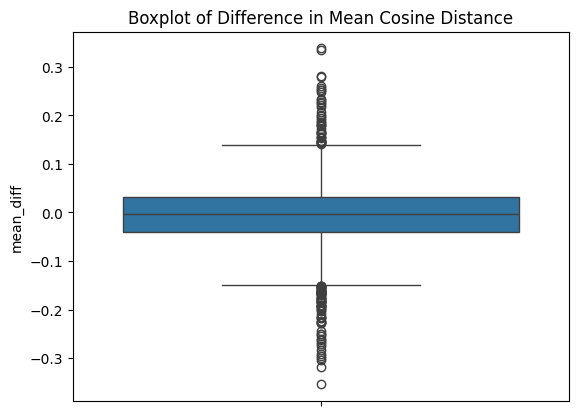

In [106]:
sns.boxplot(y=mean_cosine_distance_wide['mean_diff']).\
    set(title='Boxplot of Difference in Mean Cosine Distance')

#### Check assumptions (for paired-sample t-test)

In [107]:
shapiro(mean_cosine_distance_wide['mean_diff'])

ShapiroResult(statistic=0.9612683391943463, pvalue=1.1652183184123936e-22)

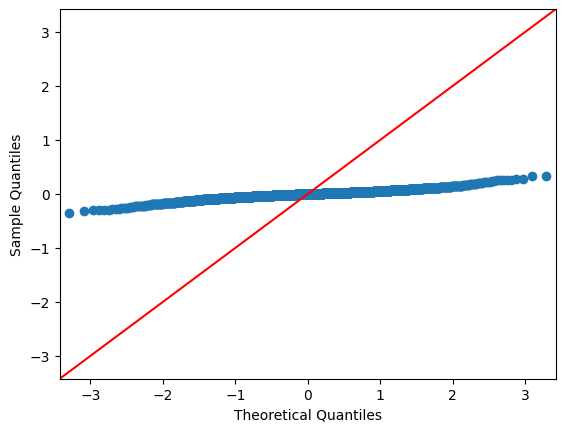

In [108]:
sm.qqplot(mean_cosine_distance_wide['mean_diff'], line ='45') 
py.show()

Both the results of Shapiro-Wilk test and QQ-plot indicates the assumption of normality (of error) is violated. Hence, we will use the non-parametric version of paired-sample t-test, i.e., **Wilcoxon signed-rank test**.

In [109]:
wilcoxon(mean_cosine_distance_wide['mean_diff'])

WilcoxonResult(statistic=901785.0, pvalue=0.0010384179908780348)

In [110]:
# Define a function using bootstrapping to calculate confidence interval of mean difference
def bootstrap_effect_size(group1, group2, n_bootstrap=10000):
    np.random.seed(42)
    bootstrapped_means_diff = []

    for _ in range(n_bootstrap):
        boot_group1 = np.random.choice(group1, size=len(group1), replace=True)
        boot_group2 = np.random.choice(group2, size=len(group2), replace=True)
        bootstrapped_means_diff.append(boot_group2.mean() - boot_group1.mean())

    # Calculate the 95% confidence interval
    lower, upper = np.percentile(bootstrapped_means_diff, [2.5, 97.5])
    
    return np.mean(bootstrapped_means_diff), lower, upper

In [111]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    mean_cosine_distance_wide['before_award'],
    mean_cosine_distance_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): -0.006341889082910074, 95% CI: [-0.010373143294593618, -0.00219632177906876]


**Discussion**:

Both the results of Wilcoxon signed-rank test and bootstrapped confidence interval of mean difference indicate that there is a significant difference between the research topic diversity before and after an author receives the NSF funding. Specifically, an author's diversity of research topics decrease after receiving the NSF funding.

### Entropy of consine distance

In [112]:
# Define a function to calculate the entropy of cosine distance within the embedding 
# matrix of the author's publications (either before or after NSF funding): A 
# higher entropy value suggests a more diverse or spread-out set of distances
def calculate_cosine_distance_entropy(embedding_matrix):
    cosine_distance = pdist(embedding_matrix, 'cosine')
 
    # Normalize cosine distances to sum to 1
    distance_probabilities = cosine_distance / np.sum(cosine_distance)
    cosine_distance_entropy = entropy(distance_probabilities, base=2)

    return cosine_distance_entropy

group_by_embedding["cosine_distance_entropy"] = group_by_embedding["embedding_matrix"].\
    apply(lambda row: calculate_cosine_distance_entropy(row))

In [113]:
# Convert the dataframe about mean_cosine_distance from long to wide format
cosine_distance_entropy_wide = group_by_embedding.pivot(index='email', 
                                                        columns='before_after_award', 
                                                        values='cosine_distance_entropy')
cosine_distance_entropy_wide.columns.name = None
cosine_distance_entropy_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,7.905158,7.894687
a.satpute@northeastern.edu,7.607206,6.310275
aabrewer@uci.edu,4.728154,6.931941
aag6@psu.edu,6.059200,6.532294
aam72@georgetown.edu,6.869627,7.620829
...,...,...
zkrizan@iastate.edu,5.583540,6.436101
zoe.wool@rice.edu,4.302202,5.043054
zook@uky.edu,10.195597,10.938481


#### Check descriptive statistics of difference in cosine_distance_entropy

In [114]:
cosine_distance_entropy_wide['entropy_diff'] = cosine_distance_entropy_wide['after_award'] - cosine_distance_entropy_wide['before_award']
print(len(cosine_distance_entropy_wide))
# Drop missing values
cosine_distance_entropy_wide.dropna(axis=0, inplace=True)
print(len(cosine_distance_entropy_wide))

1993
1992


In [115]:
cosine_distance_entropy_wide.apply(np.mean, axis=0)

after_award     6.585283
before_award    7.211661
entropy_diff   -0.626379
dtype: float64

[Text(0.5, 1.0, 'Boxplot of Difference in Entropy of Cosine Distance')]

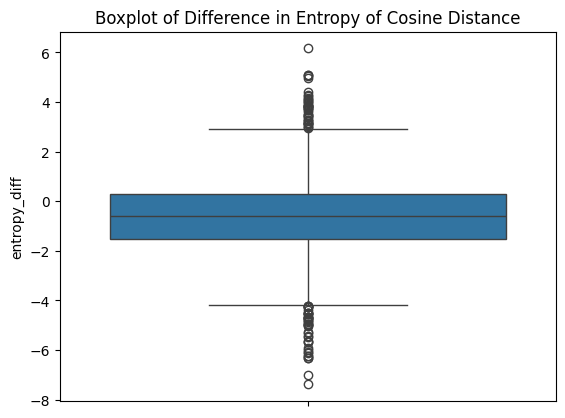

In [116]:
sns.boxplot(y=cosine_distance_entropy_wide['entropy_diff']).\
    set(title='Boxplot of Difference in Entropy of Cosine Distance')

#### Check assumptions (for paired-sample t-test)

In [117]:
shapiro(cosine_distance_entropy_wide['entropy_diff'])

ShapiroResult(statistic=0.9842136061301034, pvalue=4.95174012779043e-14)

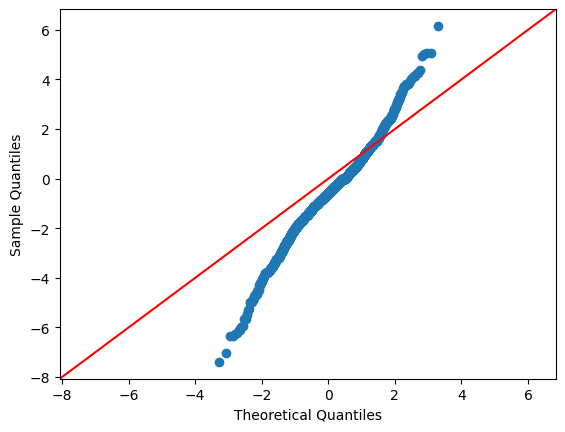

In [118]:
sm.qqplot(cosine_distance_entropy_wide['entropy_diff'], line ='45') 
py.show()

Both the results of Shapiro-Wilk test and QQ-plot indicates the assumption of normality (of error) is violated. Hence, we will use the non-parametric version of paired-sample t-test, i.e., **Wilcoxon signed-rank test**.

In [119]:
wilcoxon(cosine_distance_entropy_wide['entropy_diff'])

WilcoxonResult(statistic=529957.0, pvalue=1.1430101155707752e-66)

In [27]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    cosine_distance_entropy_wide['before_award'],
    cosine_distance_entropy_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): -0.6266795638734182, 95% CI: [-0.8158749414923414, -0.4419406910758808]


**Discussion**:

Both the results of Wilcoxon signed-rank test and bootstrapped confidence interval of mean difference indicate that there is a significant difference between the research topic diversity before and after an author receives the NSF funding. Specifically, an author's diversity of research topics decrease after receiving the NSF funding.

Together with the the results of mean_cosine_distance, distance-based approach provides strong support for the **"trap" of research funding** (in terms of research diversity).

# Perform Hierarchical Clustering of Vectors of Cosine Distance

## Convert to (pairwise) distance matrix

In [93]:
# Define a function to calculate the (pairwise) cosine distance matrix within the embedding 
# matrix of the author's publications (either before or after NSF funding)
def calculate_cosine_distance_matrix(embedding_matrix):
    cosine_distance = pdist(embedding_matrix, 'cosine')
    cosine_distance_matrix = squareform(cosine_distance)
    return cosine_distance_matrix

In [32]:
group_by_embedding["cosine_distance_matrix"] = group_by_embedding["embedding_matrix"].\
    apply(lambda row: calculate_cosine_distance_matrix(row))

## Perform hierarichal clustering

In [44]:
# Remove rows with only one paper abstract
group_by_embedding = group_by_embedding[group_by_embedding["cosine_distance_matrix"].apply(lambda row: row.shape) != (1,1)]

In [45]:
# Remove authors (emails) with either no before_award or no_award
before_after_count = group_by_embedding.groupby(by='email')['before_after_award'].count()
filtered_email = before_after_count.index[np.where(before_after_count < 2)[0].tolist()]

group_by_embedding = group_by_embedding[~group_by_embedding['email'].isin(filtered_email)]
group_by_embedding

,email,before_after_award,embedding_matrix,mean_cosine_distance,cosine_distance_entropy,cosine_distance_matrix
0,00t0holtgrav@bsu.edu,after_award,"[[-0.32955742, -0.5743396, -0.97046256, 0.2215...",0.225915,7.905158,"[[0.0, 0.24487056097264404, 0.0655054972615338..."
1,00t0holtgrav@bsu.edu,before_award,"[[-0.30634096, -0.4522231, -0.97391766, -0.939...",0.264751,7.894687,"[[0.0, 0.16214069541189446, 0.1240591396139629..."
2,a.satpute@northeastern.edu,after_award,"[[-0.32639113, -0.16873796, -0.15368238, 0.286...",0.236865,7.607206,"[[0.0, 0.2243770669730849, 0.15926944551408184..."
3,a.satpute@northeastern.edu,before_award,"[[-0.3914881, -0.11487491, -0.9629283, -0.3523...",0.253264,6.310275,"[[0.0, 0.13635626581841054, 0.2639823245279238..."
4,aabrewer@uci.edu,after_award,"[[-0.4823957, -0.40220445, -0.99880356, -0.968...",0.227764,4.728154,"[[0.0, 0.33605013846371534, 0.2835891033739369..."
...,...,...,...,...,...,...
4022,zook@uky.edu,before_award,"[[-0.055216346, -0.15407999, -0.9122512, 0.754...",0.238168,10.938481,"[[0.0, 0.13559384301024846, 0.1712137140639575..."
4023,zulu@msu.edu,after_award,"[[-0.15892313, -0.11903335, -0.9209364, -0.578...",0.287962,6.723187,"[[0.0, 0.08053250336950457, 0.1777543845776095..."
4024,zulu@msu.edu,before_award,"[[-0.27684975, -0.20300557, -0.6392335, 0.1452...",0.285075,5.304507,"[[0.0, 0.0, 0.41665456815486757, 0.15144244205..."
4025,zygmunt.frajzyngier@colorado.edu,after_award,"[[-0.26335523, -0.17618415, -0.17456537, 0.923...",0.263132,5.212317,"[[0.0, 0.678038978890815, 0.743185531948591, 0..."


In [46]:
group_by_embedding["hierarchical_clustering"] = group_by_embedding["cosine_distance_matrix"].\
    apply(lambda row: linkage(row, method='ward'))

In [54]:
group_by_embedding["hierarchical_clustering"].apply(lambda row: row.shape)

0       (23, 4)
1       (23, 4)
2       (20, 4)
3       (13, 4)
4        (7, 4)
         ...   
4022    (66, 4)
4023    (15, 4)
4024     (9, 4)
4025     (9, 4)
4026    (18, 4)
Name: hierarchical_clustering, Length: 3864, dtype: object

In [55]:
# Find the optimal number of clusters based on Silhouette Score 
# and assign labels to the optimal number of clusters
def find_optimal_n_cluster(cosine_distance_matrix, hierarchical_clustering_matrix):
    silhouette_scores = []
    range_n_clusters = range(2, min(10, hierarchical_clustering_matrix.shape[0]))

    for n_clusters in range_n_clusters:
        cluster_labels = fcluster(hierarchical_clustering_matrix, n_clusters, criterion='maxclust')
        silhouette_avg = silhouette_score(cosine_distance_matrix, cluster_labels, metric="precomputed")
        silhouette_scores.append(silhouette_avg)

    # Determine the optimal number of clusters based on the highest silhouette score
    optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]

    # Assign cluster labels to the optimal_n_clusters
    final_cluster_labels = fcluster(hierarchical_clustering_matrix, optimal_n_clusters, criterion='maxclust')
    
    return final_cluster_labels

In [58]:
group_by_embedding["hierarchical_clustering_labels"] = group_by_embedding.apply(lambda row: find_optimal_n_cluster(row['cosine_distance_matrix'], row['hierarchical_clustering']), axis=1)

ValueError: attempt to get argmax of an empty sequence

# Examine potential mediator(s)

## Add collaboration-related information to the DataFrame

In [120]:
# Convert the string representation of a list
df['coauthors'] = df['coauthors'].apply(ast.literal_eval)

# Explode the DataFrame on the 'coauthors' column to get each collaboration on a separate row
exploded_df = df.explode('coauthors')

# Create tuples of (author's email, coauthor) for each row in the exploded DataFrame
collaborations = [(row['email'], coauthor) for _, row in exploded_df.iterrows() for coauthor in [row['coauthors']]]

In [121]:
# Create a DataFrame from the collaboration counts
collaborations_df = pd.DataFrame({
    'email': [email for email, _ in collaborations],
    'collaboration': collaborations,
})

In [122]:
collaborations_df

,email,collaboration
0,talalasad@earthlink.net,"(talalasad@earthlink.net, amjad h el-sheikh)"
1,talalasad@earthlink.net,"(talalasad@earthlink.net, yahya s al-degs)"
2,talalasad@earthlink.net,"(talalasad@earthlink.net, randa m al-as' ad)"
3,talalasad@earthlink.net,"(talalasad@earthlink.net, jamal a sweileh)"
4,talalasad@earthlink.net,"(talalasad@earthlink.net, ayman m saleh)"
...,...,...
636340,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, frank j m..."
636341,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, carl e re..."
636342,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, e wohl)"
636343,francis.j.magilligan@dartmouth.edu,"(francis.j.magilligan@dartmouth.edu, fj magill..."


## Build collaboration network for `before_award` and `right_after_award` periods

In the following section, I will use closeness centrality measure to operationalize collaboration diversity (put in another way, enclosedness of a collaboration network) for each author. Specifically, I will first construct a collaboration network for each year and then extract aggregate measures for the period (e.g., before_award or right_after_award) for each author to calculate the change in collaboration diversity.

In [123]:
# Create a new column called before_rigth_after_after_award for mediation analysis (temporal order)
# Here choose a 3-year time frame for rigth_after_award period
df.loc[df["publication_year"] <= df["award_year"], 'before_rigth_after_after_award'] = 'before_award'
df.loc[(df["publication_year"] > df["award_year"]) & (df["publication_year"] < df["award_year"] + 3), 'before_rigth_after_after_award'] = 'right_after_award'
df.loc[df["publication_year"] >= df["award_year"] + 3, 'before_rigth_after_after_award'] = 'after_award'

In [124]:
df['before_rigth_after_after_award'].value_counts()

before_rigth_after_after_award
before_award         62816
right_after_award    34845
after_award          17747
Name: count, dtype: int64

In [125]:
df['before_after_award']

0         before_award
1          after_award
2          after_award
3          after_award
4          after_award
              ...     
115403    before_award
115404    before_award
115405    before_award
115406    before_award
115407    before_award
Name: before_after_award, Length: 115408, dtype: object

In [126]:
# Add year related information to the collaborations_df 
collaborations_df = pd.merge(df[['email', 'publication_year', 'before_after_award']], 
                             collaborations_df, on='email', how='inner')

In [127]:
# Store degree and closeness centrality measures for each year in Pickle (Python's object serialization)
yearly_degree_centrality_path = '../database/yearly_degree_centrality.pkl'
yearly_closeness_centrality_path = '../database/yearly_closeness_centrality.pkl'

if os.path.exists(yearly_degree_centrality_path) and os.path.exists(yearly_closeness_centrality_path):
    with open(yearly_degree_centrality_path, 'rb') as f:
        yearly_degree_centrality = pickle.load(f)
    
    with open(yearly_closeness_centrality_path, 'rb') as f:
        yearly_closeness_centrality = pickle.load(f)
    
else:
    # Initialize a dictionary to store yearly networks
    yearly_networks = {}

    for year, group in collaborations_df.groupby('publication_year'):
        G_year = nx.Graph()
        for _, row in group.iterrows():
            author_email, coauthor = row['collaboration']
            # Dynamically count the number of collaboration between two authors for each year
            if G_year.has_edge(author_email, coauthor):
                # If it exists, increment the weight by 1
                G_year[author_email][coauthor]['weight'] += 1
            else:
                # Otherwise, add a new edge with weight 1
                G_year.add_edge(author_email, coauthor, weight=1)
            
        yearly_networks[year] = G_year

    # Store degree and closness measures for each year
    yearly_degree_centrality = {}
    yearly_closeness_centrality = {}

    for year, network in yearly_networks.items():
        print(f"Begin deriving degree centrality measures for year {year}")
        yearly_degree_centrality[year] = nx.degree_centrality(network)

        print(f"Begin deriving closeness centrality measures for year {year}")
        yearly_closeness_centrality[year] = nx.closeness_centrality(network)

    # Save the centrality measures
    with open(yearly_degree_centrality_path, 'wb') as f:
        print("Save degree centrality measure")
        pickle.dump(yearly_degree_centrality, f)

    with open(yearly_closeness_centrality_path, 'wb') as f:
        print("Save closeness centrality measure")
        pickle.dump(yearly_closeness_centrality, f)

In [130]:
grouped_years = collaborations_df.groupby(by=['email', 'before_after_award'])['publication_year'].unique()

In [131]:
group_by_centrality = []

for (email, before_after_award), years in grouped_years.items():
    degree_values = []
    closeness_values = []

    for year in years:
        # Append degree centrality measure for each author (in each year)
        if year in yearly_degree_centrality and email in yearly_degree_centrality[year]:
            degree_values.append(yearly_degree_centrality[year].get(email, 0))

        # Append closeness centrality measure for each author (in each year)
        if year in yearly_closeness_centrality and email in yearly_closeness_centrality[year]:
            closeness_values.append(yearly_closeness_centrality[year].get(email, 0))

    if sum([i != 0 for i in degree_values]) > 0:
        average_degree = sum(degree_values) / sum([i != 0 for i in degree_values])
    else:
        average_degree = 0

    if sum([i != 0 for i in degree_values]) > 0:
        average_closeness = sum(closeness_values) / sum([i != 0 for i in closeness_values])
    else:
        average_closeness = 0

    # Append to data list
    group_by_centrality.append({
        'email': email,
        'before_after_award': before_after_award,
        'average_degree': average_degree,
        'average_closeness': average_closeness
    })

group_by_centrality = pd.DataFrame(group_by_centrality)

In [132]:
# Convert the dataframe about average_degree from long to wide format
average_degree_wide = group_by_centrality.drop('average_closeness', axis=1).pivot(\
    index='email', columns='before_after_award', values='average_degree')
average_degree_wide.columns.name = None
average_degree_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,0.000766,0.000756
a.satpute@northeastern.edu,0.003191,0.000867
aabrewer@uci.edu,0.000244,0.000378
aag6@psu.edu,0.000320,0.000579
aam72@georgetown.edu,0.000522,0.000435
...,...,...
zkrizan@iastate.edu,0.000267,0.000307
zoe.wool@rice.edu,0.000157,0.000111
zook@uky.edu,0.001188,0.001222


In [ ]:
# Likewise, convert the dataframe about average_closeness from long to wide format
average_closeness_wide = group_by_centrality.drop('average_degree', axis=1).pivot(\
    index='email', columns='before_after_award', values='average_closeness')
average_closeness_wide.columns.name = None
average_closeness_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,0.160031,0.152599
a.satpute@northeastern.edu,0.177090,0.209292
aabrewer@uci.edu,0.174160,0.157203
aag6@psu.edu,0.000320,0.000579
aam72@georgetown.edu,0.192232,0.187448
...,...,...
zkrizan@iastate.edu,0.178573,0.177194
zoe.wool@rice.edu,0.000157,0.105947
zook@uky.edu,0.179656,0.175523


## Repeated measure test to test before and right after award difference in degree centrality

In [133]:
# Filter out na values
average_degree_wide.dropna(inplace=True)

In [134]:
# Calculate difference in mean_cosine_distance
average_degree_wide['mean_diff'] = average_degree_wide['after_award'] - average_degree_wide['before_award']

In [135]:
average_degree_wide.apply(np.mean, axis=0)

after_award     0.001161
before_award    0.001121
mean_diff       0.000040
dtype: float64

In [136]:
wilcoxon(average_degree_wide['mean_diff'])

WilcoxonResult(statistic=952724.0, pvalue=0.1211968700493568)

In [137]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    average_degree_wide['before_award'],
    average_degree_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): 3.918277698752575e-05, 95% CI: [-9.939896866246067e-05, 0.00017193616478637744]


## Repeated measure test to test before and right after award difference in closeness centrality

In [138]:
# Filter out na values
average_closeness_wide.dropna(inplace=True)

In [139]:
# Calculate difference in mean_cosine_distance
average_closeness_wide['mean_diff'] = average_closeness_wide['after_award'] - average_closeness_wide['before_award']

In [140]:
average_closeness_wide.apply(np.mean, axis=0)

after_award     0.168344
before_award    0.167566
mean_diff       0.000777
dtype: float64

In [141]:
wilcoxon(average_closeness_wide['mean_diff'])

WilcoxonResult(statistic=815192.0, pvalue=4.968823805141583e-12)

In [142]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    average_closeness_wide['before_award'],
    average_closeness_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): 0.000762184045084453, 95% CI: [-0.002159767249041927, 0.0036988562429706084]


# Build Linear Mixed Models to Further Examine the Effect of Funding on Research Diversity

## Merge group_by_embedding and group_by_centrality

In [143]:
group_by_embedding

,email,before_after_award,embedding_matrix,mean_cosine_distance,cosine_distance_entropy
0,00t0holtgrav@bsu.edu,after_award,"[[-0.32955742, -0.5743396, -0.97046256, 0.2215...",0.225915,7.905158
1,00t0holtgrav@bsu.edu,before_award,"[[-0.30634096, -0.4522231, -0.97391766, -0.939...",0.264751,7.894687
2,a.satpute@northeastern.edu,after_award,"[[-0.32639113, -0.16873796, -0.15368238, 0.286...",0.236865,7.607206
3,a.satpute@northeastern.edu,before_award,"[[-0.3914881, -0.11487491, -0.9629283, -0.3523...",0.253264,6.310275
4,aabrewer@uci.edu,after_award,"[[-0.4823957, -0.40220445, -0.99880356, -0.968...",0.227764,4.728154
...,...,...,...,...,...
4022,zook@uky.edu,before_award,"[[-0.055216346, -0.15407999, -0.9122512, 0.754...",0.238168,10.938481
4023,zulu@msu.edu,after_award,"[[-0.15892313, -0.11903335, -0.9209364, -0.578...",0.287962,6.723187
4024,zulu@msu.edu,before_award,"[[-0.27684975, -0.20300557, -0.6392335, 0.1452...",0.285075,5.304507
4025,zygmunt.frajzyngier@colorado.edu,after_award,"[[-0.26335523, -0.17618415, -0.17456537, 0.923...",0.263132,5.212317


In [144]:
group_by_centrality

,email,before_after_award,average_degree,average_closeness
0,00t0holtgrav@bsu.edu,after_award,0.000766,0.160031
1,00t0holtgrav@bsu.edu,before_award,0.000756,0.152599
2,a.satpute@northeastern.edu,after_award,0.003191,0.177090
3,a.satpute@northeastern.edu,before_award,0.000867,0.209292
4,aabrewer@uci.edu,after_award,0.000244,0.174160
...,...,...,...,...
4022,zook@uky.edu,before_award,0.001222,0.175523
4023,zulu@msu.edu,after_award,0.000463,0.178312
4024,zulu@msu.edu,before_award,0.000574,0.174606
4025,zygmunt.frajzyngier@colorado.edu,after_award,0.000177,0.171520


In [147]:
# Merge group_by_embedding and group_by_centrality together
group_by_merged = pd.merge(group_by_centrality, group_by_embedding.drop('embedding_matrix', axis=1), how='inner', on=['email', 'before_after_award'])

In [148]:
group_by_merged

,email,before_after_award,average_degree,average_closeness,mean_cosine_distance,cosine_distance_entropy
0,00t0holtgrav@bsu.edu,after_award,0.000766,0.160031,0.225915,7.905158
1,00t0holtgrav@bsu.edu,before_award,0.000756,0.152599,0.264751,7.894687
2,a.satpute@northeastern.edu,after_award,0.003191,0.177090,0.236865,7.607206
3,a.satpute@northeastern.edu,before_award,0.000867,0.209292,0.253264,6.310275
4,aabrewer@uci.edu,after_award,0.000244,0.174160,0.227764,4.728154
...,...,...,...,...,...,...
3981,zook@uky.edu,before_award,0.001222,0.175523,0.238168,10.938481
3982,zulu@msu.edu,after_award,0.000463,0.178312,0.287962,6.723187
3983,zulu@msu.edu,before_award,0.000574,0.174606,0.285075,5.304507
3984,zygmunt.frajzyngier@colorado.edu,after_award,0.000177,0.171520,0.263132,5.212317


## Build Bootstrapped Linear Model with degree and closeness centrality as time-varying covariates

In [ ]:
n_bootstraps = 1000
bootstrap_estimates = {
    'Intercept': [],
    'before_after_award': [],
    'average_degree': [],
    'average_closeness': []
}

for _ in range(n_bootstraps):
    # Resample the DataFrame with replacement at the subject (email) level
    unique_emails = group_by_merged['email'].unique()
    resampled_emails = resample(unique_emails)
    resampled_df = pd.DataFrame()
    for email in resampled_emails:
        resampled_df = pd.concat([resampled_df, group_by_merged[group_by_merged['email'] == email]])

    # Define and fit the model
    # The model includes interactions between time (before_after_award) and the covariates if needed
    model_formula = "mean_cosine_distance ~ before_after_award * average_degree + before_after_award * average_closeness"
    model = smf.mixedlm(model_formula, data=resampled_df, groups=resampled_df["email"])
    result = model.fit()

    # Store the parameter estimates
    bootstrap_estimates['Intercept'].append(result.params['Intercept'])
    if 'before_after_award[T.after]' in result.params:
        bootstrap_estimates['before_after_award'].append(result.params['before_after_award[T.after]'])
    bootstrap_estimates['average_degree'].append(result.params['average_degree'])
    bootstrap_estimates['average_closeness'].append(result.params['average_closeness'])

# Calculate the 95% confidence intervals for each parameter
ci_95 = {param: np.percentile(bootstrap_estimates[param], [2.5, 97.5]) for param in bootstrap_estimates}

for param, ci in ci_95.items():
    print(f"{param}: 95% CI = {ci}")